In [1]:
import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

import time

import test

cascade_classifier_path = '../env-tcc/lib/python3.6/site-packages/cv2/data/'
checkpoint_dir_path = './model_logs/release_celeba_256/'

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-10-28 15:17:36 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-10-28 15:17:36 @__init__.py:80] Saving logging to file: neuralgym_logs/20181028151736745882.


In [2]:
# Imagem a ser carregada
IMG_NUMBER = '0'
source_jpg = 'img_' + IMG_NUMBER + '.jpg'

# Caminho + nome da imagem original
img_filepath = './images/' + source_jpg

# Caminho + nome da mascara
mask_filepath = './masks/' + 'mask_'+ source_jpg

# Caminho + nome da restauracao com OpenCV 
inpaint_opencv_filepath = './inpaints/' + 'inpaint_opencv_' + source_jpg

# Caminho + nome da restauracao com Generative Contextual Attention
inpaint_generative_filepath = './inpaints/' + 'inpaint_generative_' + source_jpg

print('img_filepath                  ' + img_filepath)
print('mask_filepath                 ' + mask_filepath)
print('inpaint_opencv_filepath       ' + inpaint_opencv_filepath)
print('inpaint_generative_filepath   ' + inpaint_generative_filepath)

img_filepath                  ./images/img_0.jpg
mask_filepath                 ./masks/mask_img_0.jpg
inpaint_opencv_filepath       ./inpaints/inpaint_opencv_img_0.jpg
inpaint_generative_filepath   ./inpaints/inpaint_generative_img_0.jpg


height    256
width     256
channels  3


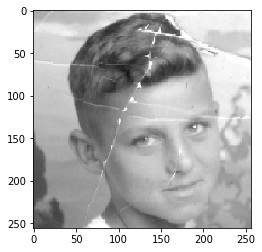

In [3]:
# Restricao de tamanho minimo 256 x 256 px e formato jpg
try:
    image = cv2.imread(img_filepath)
    height, width, channels = image.shape
    
    if (height or width) < 256:
        print('A imagem de entrada deve ter pelo menos 256 x 256 px '
              + '(imagem atual: ' + str(width) + ' x ' + str(height) + ' px)')
        #exit()
    else:
        plt.imshow(image)
        print('height    ' + str(height))
        print('width     ' + str(width))
        print('channels  ' + str(channels))
except:
    print('Imagem invalida (' + img_filepath + '). Verifique se o arquivo existe e se esta no formato .jpg')
    #exit()

<h1>Identificação do rosto e olhos</h1>

CPU times: user 135 ms, sys: 16 ms, total: 151 ms
Wall time: 81.2 ms


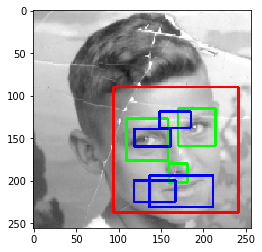

In [4]:
%%time

face_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cascade_classifier_path + 'haarcascade_smile.xml')


img = cv2.imread(img_filepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray) #green
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    smile = smile_cascade.detectMultiScale(roi_gray) #blue
    for (ex,ey,ew,eh) in smile:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)

i = np.asarray(img)

plt.imshow(i)

<h1> Criação da máscada </h1>

CPU times: user 17.3 ms, sys: 0 ns, total: 17.3 ms
Wall time: 12.2 ms


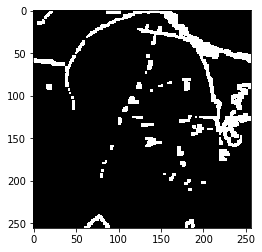

In [5]:
%%time

# Create HSV and grayscale formats
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define variables used in masking
max_gray = np.amax(gray)
min_color = np.array([0,0,max_gray-60])
max_color = np.array([255,60,max_gray])

# Create initial region mask
reg = cv2.inRange(hsv, min_color, max_color)

# plt.imshow(gray, cmap="gray")

# Blur the image for better line detection
blur = cv2.GaussianBlur(gray,(3, 3),0)

# Define morphologial transformation kernel
kernel = np.ones((3,3),np.uint8)

# Create edges and dilate to get better results
edges = cv2.Canny(gray, 100, 150)
edges = cv2.dilate(edges, kernel)

# plt.imshow(edges, cmap="gray")

# Intersect region and edges
mask = reg & edges
mask = cv2.dilate(mask, kernel)

# Save mask
cv2.imwrite(mask_filepath, mask)

plt.imshow(mask, cmap="gray")

<h1>Inpaint com Deep Generative Model with Contextual Attention</h1>

[2018-10-28 15:17:42 @gpus.py:39] Error reading GPU information, set no GPU.


Shape of image: (256, 256, 3)
Model loaded.
./inpaints/inpaint_generative_img_0.jpg
CPU times: user 5.59 s, sys: 600 ms, total: 6.19 s
Wall time: 2.99 s


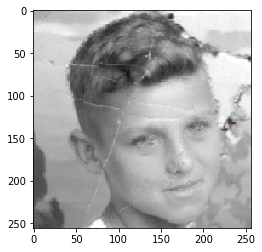

In [6]:
%%time

test.run_inpaint(image = img_filepath, 
                 mask = mask_filepath, 
                 output = inpaint_generative_filepath, 
                 checkpoint_dir = checkpoint_dir_path)

plt.imshow(np.asarray(Image.open(inpaint_generative_filepath)))
print(inpaint_generative_filepath)

<h1>Inpaint com OpenCV</h1>

./inpaints/inpaint_opencv_img_0.jpg
CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 40.2 ms


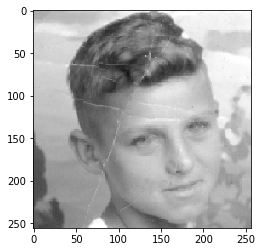

In [7]:
%%time

inpaint = cv2.inpaint(image,mask,3,cv2.INPAINT_TELEA)
save = cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB)

# Save inpaint 
cv2.imwrite(inpaint_opencv_filepath, save)

plt.imshow(inpaint)
print(inpaint_opencv_filepath)